In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Importing the required packages

In [2]:
import os
import torch
import torch.nn as n
import torch.nn.functional as f
import numpy as np
import os
from torchsummary import summary
import torch.optim as optim
from tqdm import tqdm
from torchvision import models
import cv2
from matplotlib import pyplot as plt
from PIL import Image
from pathlib import Path

Defining the celebrity dataset folder and listing all images

In [3]:
#download images from google drive and save locally
!unzip '/content/drive/MyDrive/University/Applied AI/Midterm/Data/train.zip' -d '/content'

Streaming output truncated to the last 5000 lines.
  inflating: /content/train/dog.5499.jpg  
  inflating: /content/train/dog.55.jpg  
  inflating: /content/train/dog.550.jpg  
  inflating: /content/train/dog.5500.jpg  
  inflating: /content/train/dog.5501.jpg  
  inflating: /content/train/dog.5502.jpg  
  inflating: /content/train/dog.5503.jpg  
  inflating: /content/train/dog.5504.jpg  
  inflating: /content/train/dog.5505.jpg  
  inflating: /content/train/dog.5506.jpg  
  inflating: /content/train/dog.5507.jpg  
  inflating: /content/train/dog.5508.jpg  
  inflating: /content/train/dog.5509.jpg  
  inflating: /content/train/dog.551.jpg  
  inflating: /content/train/dog.5510.jpg  
  inflating: /content/train/dog.5511.jpg  
  inflating: /content/train/dog.5512.jpg  
  inflating: /content/train/dog.5513.jpg  
  inflating: /content/train/dog.5514.jpg  
  inflating: /content/train/dog.5515.jpg  
  inflating: /content/train/dog.5516.jpg  
  inflating: /content/train/dog.5517.jpg  
  infla

In [4]:
catDogData = '/content/train'
images = os.listdir(catDogData)
imageList = images[:25000]

In [5]:
len(imageList)

24988

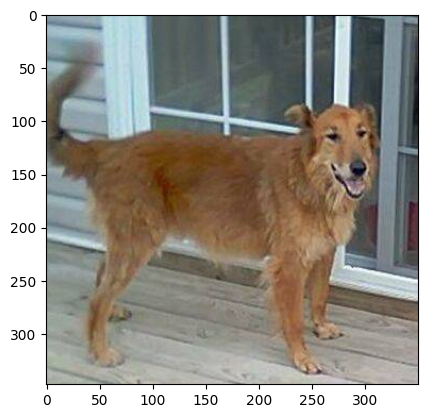

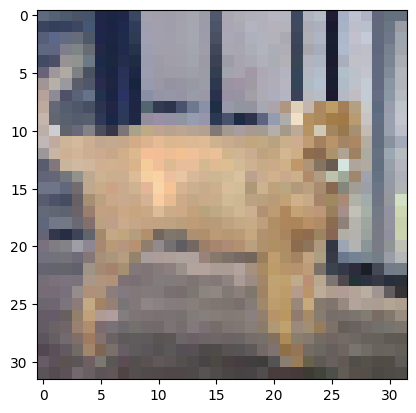

In [32]:
originalImage = plt.imread(os.path.join(catDogData, imageList[1]))
modifiedImage = cv2.resize(cv2.GaussianBlur(cv2.imread(os.path.join(catDogData, imageList[1])),(5,5),cv2.BORDER_DEFAULT),(32,32))

image1 = Image.fromarray((originalImage).astype('uint8'))
plt.figure(1)
plt.imshow(image1)
plt.figure(2)
image2 = Image.fromarray((modifiedImage * 255).astype('uint8'))
plt.imshow(image2)

Assigning the device as cuda if GPU is available else cpu

In [7]:
cuda = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Defining the generator architecture as given the reference paper

In [8]:
class Generator(n.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = n.Conv2d(3,64,9,padding=4,bias=False)
        self.conv2 = n.Conv2d(64,64,3,padding=1,bias=False)
        self.conv3_1 = n.Conv2d(64,256,3,padding=1,bias=False)
        self.conv3_2 = n.Conv2d(64,256,3,padding=1,bias=False)
        self.conv4 = n.Conv2d(64,3,9,padding=4,bias=False)
        self.bn = n.BatchNorm2d(64)
        self.ps = n.PixelShuffle(2)
        self.prelu = n.PReLU()

    def forward(self,x):
        block1 = self.prelu(self.conv1(x))
        block2 = torch.add(self.bn(self.conv2(self.prelu(self.bn(self.conv2(block1))))),block1)
        block3 = torch.add(self.bn(self.conv2(self.prelu(self.bn(self.conv2(block2))))),block2)
        block4 = torch.add(self.bn(self.conv2(self.prelu(self.bn(self.conv2(block3))))),block3)
        block5 = torch.add(self.bn(self.conv2(self.prelu(self.bn(self.conv2(block4))))),block4)
        block6 = torch.add(self.bn(self.conv2(self.prelu(self.bn(self.conv2(block5))))),block5)
        block7 = torch.add(self.bn(self.conv2(block6)),block1)
        block8 = self.prelu(self.ps(self.conv3_1(block7)))
        block9 = self.prelu(self.ps(self.conv3_2(block8)))
        block10 = self.conv4(block9)
        return block10

Assigning the Generator to cuda(if available) and printing the summary of the Generator with a dummy input

In [9]:
gen = Generator().to(cuda)

#Uncomment below mentioned three lines if you have more than one gpu and want to use all of them
#ngpu=2
# if (cuda.type == 'cuda') and (ngpu > 1):
#     gen = n.DataParallel(gen, list(range(ngpu)))
summary(gen,(3,32,32))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]          15,552
             PReLU-2           [-1, 64, 32, 32]               1
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
             PReLU-5           [-1, 64, 32, 32]               1
            Conv2d-6           [-1, 64, 32, 32]          36,864
       BatchNorm2d-7           [-1, 64, 32, 32]             128
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
            PReLU-10           [-1, 64, 32, 32]               1
           Conv2d-11           [-1, 64, 32, 32]          36,864
      BatchNorm2d-12           [-1, 64, 32, 32]             128
           Conv2d-13           [-1, 64, 32, 32]          36,864
      BatchNorm2d-14           [-1, 64,

Defining the Discriminator network as given in the reference paper expect that a dropout in the last layer

In [10]:
class Discriminator(n.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = n.Conv2d(3,64,3,padding=1,bias=False)
        self.conv2 = n.Conv2d(64,64,3,stride=2,padding=1,bias=False)
        self.bn2 = n.BatchNorm2d(64)
        self.conv3 = n.Conv2d(64,128,3,padding=1,bias=False)
        self.bn3 = n.BatchNorm2d(128)
        self.conv4 = n.Conv2d(128,128,3,stride=2,padding=1,bias=False)
        self.bn4 = n.BatchNorm2d(128)
        self.conv5 = n.Conv2d(128,256,3,padding=1,bias=False)
        self.bn5 = n.BatchNorm2d(256)
        self.conv6 = n.Conv2d(256,256,3,stride=2,padding=1,bias=False)
        self.bn6 = n.BatchNorm2d(256)
        self.conv7 = n.Conv2d(256,512,3,padding=1,bias=False)
        self.bn7 = n.BatchNorm2d(512)
        self.conv8 = n.Conv2d(512,512,3,stride=2,padding=1,bias=False)
        self.bn8 = n.BatchNorm2d(512)
        #self.fc1 = n.Linear(512*16*16,1024)
        self.fc1 = n.Linear(512*8*8,1024)
        self.fc2 = n.Linear(1024,1)
        self.drop = n.Dropout2d(0.3)

    def forward(self,x):
        block1 = f.leaky_relu(self.conv1(x))
        block2 = f.leaky_relu(self.bn2(self.conv2(block1)))
        block3 = f.leaky_relu(self.bn3(self.conv3(block2)))
        block4 = f.leaky_relu(self.bn4(self.conv4(block3)))
        block5 = f.leaky_relu(self.bn5(self.conv5(block4)))
        block6 = f.leaky_relu(self.bn6(self.conv6(block5)))
        block7 = f.leaky_relu(self.bn7(self.conv7(block6)))
        block8 = f.leaky_relu(self.bn8(self.conv8(block7)))
        block8 = block8.view(-1,block8.size(1)*block8.size(2)*block8.size(3))
        block9 = f.leaky_relu(self.fc1(block8),)
#         block9 = block9.view(-1,block9.size(1)*block9.size(2)*block9.size(3))
        block10 = torch.sigmoid(self.drop(self.fc2(block9)))
        return block9,block10

Assigning the discriminator to the gpu(if available) and printing the summary of the network with a dummy value

In [11]:
disc = Discriminator().to(cuda)
#summary(disc,(3,256,256))
summary(disc,(3,128,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,728
            Conv2d-2           [-1, 64, 64, 64]          36,864
       BatchNorm2d-3           [-1, 64, 64, 64]             128
            Conv2d-4          [-1, 128, 64, 64]          73,728
       BatchNorm2d-5          [-1, 128, 64, 64]             256
            Conv2d-6          [-1, 128, 32, 32]         147,456
       BatchNorm2d-7          [-1, 128, 32, 32]             256
            Conv2d-8          [-1, 256, 32, 32]         294,912
       BatchNorm2d-9          [-1, 256, 32, 32]             512
           Conv2d-10          [-1, 256, 16, 16]         589,824
      BatchNorm2d-11          [-1, 256, 16, 16]             512
           Conv2d-12          [-1, 512, 16, 16]       1,179,648
      BatchNorm2d-13          [-1, 512, 16, 16]           1,024
           Conv2d-14            [-1, 51

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


In [12]:
disc = Discriminator().to(cuda).float()
gen = Generator().to(cuda).float()

Downloading the pretrained vgg19 model from model module of torchvision library

In [13]:
vgg = models.vgg19(pretrained=True).to(cuda)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:05<00:00, 101MB/s] 


Defining the losses to be used in training

In [14]:
gen_loss = n.BCELoss()
vgg_loss = n.MSELoss()
mse_loss = n.MSELoss()
disc_loss = n.BCELoss()

Defining the adam optimizers for generator and discriminator

In [15]:
gen_optimizer = optim.Adam(gen.parameters(),lr=0.0001)
disc_optimizer = optim.Adam(disc.parameters(),lr=0.0001)

Loading the images after based on resizing as numpy array

In [16]:
def loadImages(imageList,path,resize=False):
    images=[]
    for image in (imageList):
#         print(image)
        if resize:
            #img = cv2.resize(cv2.imread(os.path.join(path,image)),(256,256))
            img = cv2.resize(cv2.imread(os.path.join(path,image)),(128,128))
        else:
            img = cv2.imread(os.path.join(path,image))
#         img = img.reshape(img.shape[2],img.shape[0],img.shape[1])
#         print(img.shape)
        img = np.moveaxis(img, 2, 0)
#         print(img.shape)
        images.append(img)
    return np.array(images)

Converting the high resolution images into low resolution by applying gaussian blur, resizing in to 64*64 and loading it as numpy array

In [17]:
def loadLRImages(imagelist,path):
    images=[]
    for image in (imagelist):
        #img = cv2.resize(cv2.GaussianBlur(cv2.imread(os.path.join(path,image)),(5,5),cv2.BORDER_DEFAULT),(64,64))
        img = cv2.resize(cv2.GaussianBlur(cv2.imread(os.path.join(path,image)),(5,5),cv2.BORDER_DEFAULT),(32,32))
#         img = img.reshape(img.shape[2],img.shape[0],img.shape[1])
        img = np.moveaxis(img, 2, 0)
        images.append(img)
    return np.array(images)

Loading the generator model from the given checkpoint

In [18]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = checkpoint['model']
    model.load_state_dict(checkpoint['state_dict'])
    for parameter in model.parameters():
        parameter.requires_grad = False

    model.eval()

    return model

Given low resolution images and checkpoint, Generating the high resolution images out of it

In [19]:
def imagePostProcess(imagedir,modelPath):
    imagelist=[]
#     images = os.listdir(imagedir)
    for img in imagedir:
        img = cv2.resize(cv2.GaussianBlur(cv2.imread(os.path.join(hr_path,img)),(5,5),cv2.BORDER_DEFAULT),(32,32))
        imagelist.append(img)
    imagearray = np.array(imagelist)/255
#     imagearray = (imagedir)/255
    # imagearrayPT = np.reshape(imagearray,(len(imagelist),imagearray.shape[3],imagearray.shape[1],imagearray.shape[2]))
    imagearrayPT = np.moveaxis(imagearray,3,1)
    # print(imagearrayPT.shape)

    model = load_checkpoint(modelPath)
    im_tensor = torch.from_numpy(imagearrayPT).float()
    out_tensor = model(im_tensor)
    # print(out_tensor.shape)
    # out = np.reshape(out_tensor,[out_tensor.shape[0],out_tensor.shape[2],out_tensor.shape[3],out_tensor.shape[1]])
    out = out_tensor.numpy()
    out = np.moveaxis(out,1,3)
    # print(out.shape)
    out = np.clip(out,0,1)

    return out

Display utility of displaying images using matplotlib

In [20]:
def show_samples(sample_images):
    figure, axes = plt.subplots(1, sample_images.shape[0], figsize = (10,10))
    for index, axis in enumerate(axes):
        axis.axis('off')
        image_array = sample_images[index]
        axis.imshow(image_array)
        image = Image.fromarray((image_array * 255).astype('uint8'))
    plt.savefig(os.path.join(base_path,"out/SR")+"_"+str(epoch)+".png", bbox_inches='tight', pad_inches=0)
    plt.show()
    plt.close()

In [21]:
#change the batch-size based on your system memory

#lower to not crash it
#12.7 GB
epochs=150
batch_size=64

In [22]:
import os
#base_path = os.getcwd()
#set base path to your google drive folder where you are saving everything
base_path = Path('/content/drive/MyDrive/University/Applied AI/Midterm')

#lr_path = os.path.join(base_path,"trainImages")
#hr_path =celebData
hr_path =catDogData
#valid_path = os.path.join(base_path,"SR_valid")
weight_file = os.path.join(base_path,"SRPT_weights")
out_path = os.path.join(base_path,"out")

if not os.path.exists(weight_file):
    os.makedirs(weight_file)

if not os.path.exists(out_path):
    os.makedirs(out_path)


#LR_images_list = os.listdir(lr_path)
HR_images_list = imageList
batch_count = len(HR_images_list)//batch_size
batch_count

390

Starting of training and defining losses

In [26]:
#model = load_checkpoint(Path('/content/drive/MyDrive/University/Applied AI/Midterm/SRPT_weights/SR148.pth'))

100%|██████████| 390/390 [04:11<00:00,  1.55it/s]


Epoch ::::  150  d1_loss ::: 0.20858287320305138  d2_loss :::0.2115542962956123
genLoss ::: 22.505113391387155  vggLoss ::: 0.22157844110177113  MeanLoss  ::: 0.005699161369687854


100%|██████████| 390/390 [04:12<00:00,  1.55it/s]


Epoch ::::  151  d1_loss ::: 0.20813854758938152  d2_loss :::0.21022132226289847
genLoss ::: 22.61311967800825  vggLoss ::: 0.22145289664085094  MeanLoss  ::: 0.005696306085118498


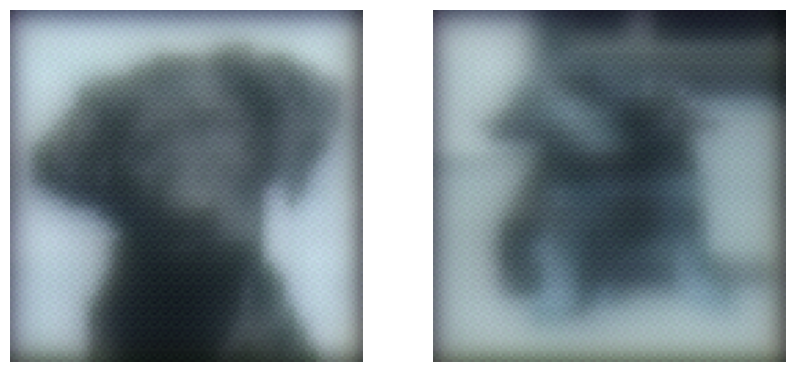

In [27]:
#batch_count=60
for epoch in range(epochs):
    d1loss_list=[]
    d2loss_list=[]
    gloss_list=[]
    vloss_list=[]
    mloss_list=[]

    for batch in tqdm(range(batch_count)):
        hr_imagesList = [img for img in HR_images_list[batch*batch_size:(batch+1)*batch_size]]
        lr_images = loadLRImages(hr_imagesList,hr_path)/255
        hr_images = loadImages(hr_imagesList,hr_path,True)/255

        disc.zero_grad()

        gen_out = gen(torch.from_numpy(lr_images).to(cuda).float())
        _,f_label = disc(gen_out)
        _,r_label = disc(torch.from_numpy(hr_images).to(cuda).float())
        d1_loss = (disc_loss(f_label,torch.zeros_like(f_label,dtype=torch.float)))
        d2_loss = (disc_loss(r_label,torch.ones_like(r_label,dtype=torch.float)))
        # d_loss = d1_loss+d2_loss
        d2_loss.backward()
        d1_loss.backward(retain_graph=True)
        # print(d1_loss,d2_loss)
#         d_loss.backward(retain_graph=True)
        disc_optimizer.step()


        gen.zero_grad()
        g_loss = gen_loss(f_label.data,torch.ones_like(f_label,dtype=torch.float))
        v_loss = vgg_loss(vgg.features[:7](gen_out),vgg.features[:7](torch.from_numpy(hr_images).to(cuda).float()))
        m_loss = mse_loss(gen_out,torch.from_numpy(hr_images).to(cuda).float())

        generator_loss = g_loss + v_loss + m_loss
        # v_loss.backward(retain_graph=True)
        # m_loss.backward(retain_graph=True)
        # g_loss.backward()
        # print(generator_loss)

        generator_loss.backward()
        gen_optimizer.step()

        d1loss_list.append(d1_loss.item())
        d2loss_list.append(d2_loss.item())

        gloss_list.append(g_loss.item())
        vloss_list.append(v_loss.item())
        mloss_list.append(m_loss.item())



#         print("d1Loss ::: "+str((d1_loss.item()))+" d2Loss ::: "+str((d2_loss.item())))
#         print("gloss ::: "+str((g_loss.item()))+" vloss ::: "+str((v_loss.item()))+" mloss ::: "+str((m_loss.item())))
    print("Epoch ::::  "+str(epoch+1)+"  d1_loss ::: "+str(np.mean(d1loss_list))+"  d2_loss :::"+str(np.mean(d2loss_list)))
    print("genLoss ::: "+str(np.mean(gloss_list))+"  vggLoss ::: "+str(np.mean(vloss_list))+"  MeanLoss  ::: "+str(np.mean(mloss_list)))

    if(epoch%3==0):

        checkpoint = {'model': Generator(),
              'input_size': 32,
              'output_size': 128,
              'state_dict': gen.state_dict()}
        #save locally, will be deleted
        #torch.save(checkpoint,os.path.join(weight_file,"SR"+str(epoch+1)+".pth"))
        #save to google drive
        torch.save(checkpoint,os.path.join(weight_file,"SR"+str(epoch+1)+".pth"))
        torch.cuda.empty_cache()

        out_images = imagePostProcess(images[-2:],os.path.join(weight_file,"SR"+str(epoch+1)+".pth"))
#         print(out_images.shape)
#         test_images = loadLRImages(images[:-3],hr_path)/255
#         test_images = np.reshape(test_images,(test_images[0],test_images.shape[3],test_images.shape[1],test_images.shape[2]))
#         out_images = gen(torch.from_numpy(test_images).to(cuda).float())
#         out_images = np.reshape(out_images,(out_images[0],out_images[2],out_images[3],out_images[1]))
        show_samples(out_images)


Generate images using trained model

In [37]:
#load images into list
catDogData = '/content/train'
imageDirectory = Path(catDogData)
images = os.listdir(catDogData)
imageList = images[:25000]
path = catDogData
#path to the best trained model
pathToLastModel = Path('/content/drive/MyDrive/University/Applied AI/Midterm/SRPT_weights/SR151.pth')
#assign the generator
generator = Generator()
#make folder to save to locally
tempSaveLocation = Path('/content/generated images')
#create temporary save directory
if not os.path.exists(tempSaveLocation):
    os.makedirs(tempSaveLocation)
torch.cuda.empty_cache()
imagelist=[]
namelist = []
model = load_checkpoint(pathToLastModel)
batchSize = 60
for img in images:
    namelist.append(img) #save name of image
    resizedImage = cv2.resize(cv2.GaussianBlur(cv2.imread(os.path.join(hr_path,img)),(5,5),cv2.BORDER_DEFAULT),(32,32))
    imagelist.append(resizedImage)
    if(len(imagelist) >= batchSize or (len(os.listdir(tempSaveLocation)) + len(imagelist)) >= len(images)):
      #convert the images to low resolution
      imagearray = np.array(imagelist)/255
      imagearrayPT = np.moveaxis(imagearray,3,1)
      im_tensor = torch.from_numpy(imagearrayPT).float()
      out_tensor = model(im_tensor)
      out = out_tensor.numpy()
      out = np.moveaxis(out,1,3)
      out = np.clip(out,0,1)
      name = 0
      for finalImage in out:
        image = Image.fromarray((finalImage * 255).astype('uint8'))
        image.save(os.path.join(tempSaveLocation)+"/"+ namelist[name])
        name = name + 1
      namelist.clear()
      imagelist.clear() #empty the list
      imagesSaved = len(os.listdir(tempSaveLocation))
      print("progress: {} images saved. {} images total.".format(imagesSaved, len(images)))



progress: 60 images saved. 24988 images total.
progress: 120 images saved. 24988 images total.
progress: 180 images saved. 24988 images total.
progress: 240 images saved. 24988 images total.
progress: 300 images saved. 24988 images total.
progress: 360 images saved. 24988 images total.
progress: 420 images saved. 24988 images total.
progress: 480 images saved. 24988 images total.
progress: 540 images saved. 24988 images total.
progress: 600 images saved. 24988 images total.
progress: 660 images saved. 24988 images total.
progress: 720 images saved. 24988 images total.
progress: 780 images saved. 24988 images total.
progress: 840 images saved. 24988 images total.
progress: 900 images saved. 24988 images total.
progress: 960 images saved. 24988 images total.
progress: 1020 images saved. 24988 images total.
progress: 1080 images saved. 24988 images total.
progress: 1140 images saved. 24988 images total.
progress: 1200 images saved. 24988 images total.
progress: 1260 images saved. 24988 im

Zip the new images and save them locally. Make sure to download them for future use.

In [38]:
#zip the generated pictures and save them locally
!zip -r generated images.zip '/content/generated images'

Streaming output truncated to the last 5000 lines.
  adding: content/generated images7/dog.1715.jpg (deflated 10%)
  adding: content/generated images7/dog.6944.jpg (deflated 15%)
  adding: content/generated images7/dog.1929.jpg (deflated 11%)
  adding: content/generated images7/dog.2248.jpg (deflated 14%)
  adding: content/generated images7/cat.8162.jpg (deflated 9%)
  adding: content/generated images7/cat.4351.jpg (deflated 9%)
  adding: content/generated images7/cat.11405.jpg (deflated 13%)
  adding: content/generated images7/dog.285.jpg (deflated 9%)
  adding: content/generated images7/dog.596.jpg (deflated 9%)
  adding: content/generated images7/cat.6849.jpg (deflated 10%)
  adding: content/generated images7/dog.12391.jpg (deflated 10%)
  adding: content/generated images7/dog.3604.jpg (deflated 20%)
  adding: content/generated images7/dog.2870.jpg (deflated 9%)
  adding: content/generated images7/cat.3548.jpg (deflated 9%)
  adding: content/generated images7/cat.12067.jpg (deflated

# **Training the classifier**

For this, we will run the classifier twice. Once with the high definition images we put into the srgan, and one with the output of the srgan. Once we have trained them both, we will compare the results by testing them on the same testing data set. You don't need to run anything above this point.

Download the generated images or the original ones

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Load Training Images

In [2]:
# Images that came OUT OF the gan
!unzip '/content/drive/MyDrive/University/Applied AI/Midterm/Generated Images/generated_train.zip' -d '/content'
# Images that went INTO the gan
!unzip '/content/drive/MyDrive/University/Applied AI/Midterm/Data/train.zip' -d '/content'

Streaming output truncated to the last 5000 lines.
  inflating: /content/train/dog.5499.jpg  
  inflating: /content/train/dog.55.jpg  
  inflating: /content/train/dog.550.jpg  
  inflating: /content/train/dog.5500.jpg  
  inflating: /content/train/dog.5501.jpg  
  inflating: /content/train/dog.5502.jpg  
  inflating: /content/train/dog.5503.jpg  
  inflating: /content/train/dog.5504.jpg  
  inflating: /content/train/dog.5505.jpg  
  inflating: /content/train/dog.5506.jpg  
  inflating: /content/train/dog.5507.jpg  
  inflating: /content/train/dog.5508.jpg  
  inflating: /content/train/dog.5509.jpg  
  inflating: /content/train/dog.551.jpg  
  inflating: /content/train/dog.5510.jpg  
  inflating: /content/train/dog.5511.jpg  
  inflating: /content/train/dog.5512.jpg  
  inflating: /content/train/dog.5513.jpg  
  inflating: /content/train/dog.5514.jpg  
  inflating: /content/train/dog.5515.jpg  
  inflating: /content/train/dog.5516.jpg  
  inflating: /content/train/dog.5517.jpg  
  infla

In [3]:
!pip install -q keras

import keras

from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input, Convolution2D, MaxPool2D, Dense, Flatten, Dropout
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
from keras.utils import plot_model

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from pathlib import Path
import pandas as pd
import numpy as np

from datetime import datetime
import os

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7945106045943140110
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15240134656
locality {
  bus_id: 1
  links {
  }
}
incarnation: 762756830680392225
physical_device_desc: "device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:00:04.0, compute capability: 7.0"
xla_global_id: 416903419
]


**Setup Paths and other parameters**

In [5]:
fold_num = 1

# Image size
img_width, img_height, img_depth = 128, 128, 3
data_dir = Path('/content/content/generated images')
csv_dir = Path('/content/drive/MyDrive/University/Applied AI/Midterm/Data')

# Data organization
csv_name = 'dog_cat_train.csv'
csv_path = csv_dir / csv_name
df_train = pd.read_csv(csv_path)
df_train = df_train.sample(frac = 1, random_state = fold_num)

csv_name = 'dog_cat_valid.csv'
csv_path = csv_dir / csv_name
df_valid = pd.read_csv(csv_path)
df_valid = df_train.sample(frac = 1, random_state = fold_num)

# Training parameters
epochs = 10
freq = 20
batch_size = 34
num_classes = 2
train_valid_split = 0.2
nb_train_samples = int(len(df_train) * (1-train_valid_split))
nb_valid_samples = len(df_train) - nb_train_samples

class_weights = {0: 2.,
                1: 1.,
                2: 1.}

if num_classes < 2:
    act_type = 'sigmoid'
    class_mode = 'binary'
    loss_fun = 'binary_crossentropy'
else:
    act_type = 'softmax'
    class_mode = 'categorical'
    loss_fun = 'categorical_crossentropy'

print('Type of classification: ', class_mode)
print('Loss function: ', loss_fun)
print('Activation function: ', act_type)

Type of classification:  categorical
Loss function:  categorical_crossentropy
Activation function:  softmax


**ImageDataGenerator**

Image generator and sample images

Found 19989 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 11 invalid image filename(s) in x_col="Image". These filename(s) will be ignored.
  warnings.warn(


Found 19989 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 11 invalid image filename(s) in x_col="Image". These filename(s) will be ignored.
  warnings.warn(


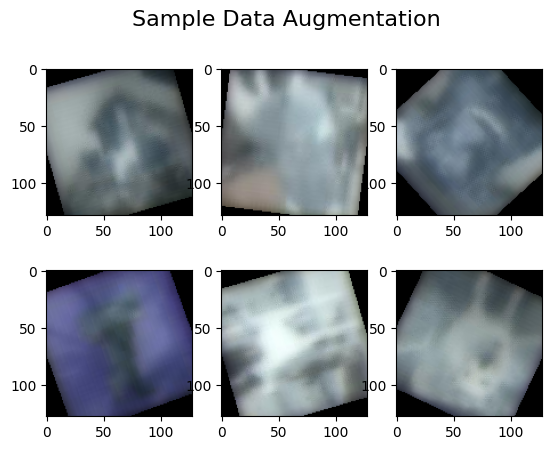

y Labels:  [[0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]]
sample img, max value:  0.8128428
sample img, min value:  0.0


In [6]:
#ImageDataGenerator
datagen = ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip = True,
    vertical_flip = True,
    rotation_range = 90,
    fill_mode = 'constant')

train_generator = datagen.flow_from_dataframe(
    dataframe = df_train,
    directory = data_dir,
    target_size = (img_width, img_height),
    x_col = 'Image',
    y_col = 'label',
    class_mode = class_mode,
    color_mode = 'rgb',
    batch_size = batch_size,
    shuffle = True)

valid_generator = datagen.flow_from_dataframe(
    dataframe = df_valid,
    directory = data_dir,
    target_size = (img_width, img_height),
    x_col = 'Image',
    y_col = 'label',
    class_mode = class_mode,
    color_mode = 'rgb',
    batch_size = batch_size,
    shuffle = True)

# For directory

# Preview the augmented data
X_preview, y_preview = train_generator.next()

for k in range(1,7):
    sample_img = X_preview[k,:,:,:]
    plt.subplot(2, 3, k)
    plt.imshow(sample_img)
plt.suptitle('Sample Data Augmentation', fontsize = 16)
plt.show()

print('y Labels: ', y_preview[1:5])
print('sample img, max value: ',np.max(sample_img))
print('sample img, min value: ',np.min(sample_img))

**Create/Import Network**

In [7]:
# Build Model
image_input = Input(shape = (img_width, img_height, img_depth))
base_model = applications.MobileNetV2(input_tensor = image_input,
                                 include_top = False,
                                 weights = 'imagenet')

base_output = base_model.layers[-1].output

flat1 = Flatten()(base_output)
fc1 = Dense(8192, activation = 'relu')(flat1)
dropfc1 = Dropout(0.5)(fc1)
fc2 = Dense(4096, activation = 'relu')(dropfc1)
dropfc2 = Dropout(0.5)(fc2)

output = Dense(num_classes, activation = act_type)(dropfc2)

for layer in base_model.layers[:-9]:
    layer.trainable = False

model = Model(image_input, output)

# model.summary()

9406464/9406464 [==============================] - 0s 0us/step


**Model HyperParameters**

In [8]:
# Compile the model
opt = Adam(learning_rate = 0.00001)
model.compile(loss = loss_fun, optimizer = opt, metrics = ['accuracy'])

**Model Checkpointer**

In [9]:
# Folder setup
init_time = datetime.now()
current_time = init_time.strftime('%Y%m%d_%H%M%S')
name_dir = '/content/drive/MyDrive/University/Applied AI/Midterm/Generated checkpoints/Trained Models' + current_time
os.mkdir(name_dir)

# Callbacks1: ModelCheckpointer
model_file_format = name_dir + '/model_' + str(fold_num) + '_model.{epoch:04d}.hdf5'
check = ModelCheckpoint(model_file_format, period = freq, verbose = 1)

# Callbacks2: TensorBoard
tensor_check = '/content/drive/MyDrive/University/Applied AI/Midterm/Generated checkpoints/Generated Logs' + current_time + '_train_testsplit' + str(fold_num)
tensor_board = TensorBoard(tensor_check)

# Callbacks3: EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')
# Plot model
figure_name = name_dir + '/model_output.png'
plot_model(model, figure_name, show_shapes = True)

# Display model
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 64, 64, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 64, 64, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 64, 64, 32)           0         ['bn_Conv1[0][0]']        

**Train Model**

In [10]:
history = model.fit(train_generator,
                              epochs = epochs,
                              steps_per_epoch = nb_train_samples // batch_size,
                              #validation_data = valid_generator,
                              validation_steps = nb_valid_samples // batch_size,
                              callbacks = [check, tensor_board],
                              class_weight = class_weights)

early_stop_name = name_dir + '/fold_num_' + str(fold_num) + 'early_stop_model.hdf5'
model.save_weights(early_stop_name)

Epoch 1/10
234/470 [=============>................] - ETA: 37s - loss: 1.7067 - accuracy: 0.5031

KeyboardInterrupt: ignored

**Test Model**

Load the trained models and change what it will test (Accuracy, AUC, and F1)

In [22]:
GanModelLocation = Path('/content/drive/MyDrive/University/Applied AI/Midterm/Generated checkpoints/Trained Models20231106_193627/fold_num_1early_stop_model.hdf5')
NormalModelLocation = Path('/content/drive/MyDrive/University/Applied AI/Midterm/Normal checkpoints/Trained Models20231106_150807/fold_num_1early_stop_model.hdf5')

model.load_weights(GanModelLocation)
#model.load_weights(NormalModelLocation)

model.compile(loss = loss_fun, optimizer = opt, metrics = ['accuracy', 'AUC', 'FalseNegatives', 'FalsePositives'])

Set the testing data set. The test images should be the high quality ones and not the ones created with the SRGAN.

In [23]:
# Data organization
test_data_dir = Path('/content/train')
csv_name = 'dog_cat_test.csv'
csv_path = Path('/content/drive/MyDrive/University/Applied AI/HW1') / csv_name
df_test = pd.read_csv(csv_path)
df_test = df_test.sample(frac = 1, random_state = fold_num)

class_names = ['A. cat', 'B. dog']

Test each model and compare the results

In [24]:
test_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip = True,
    vertical_flip = True,
    zoom_range = 0.2,
    rotation_range = 90,
    fill_mode = 'constant')
#test_datagen = ImageDataGenerator(rescale = 1./255,preprocessing_function = imageLoader)
batchSize = 100

test_generator = test_datagen.flow_from_dataframe(dataframe = df_test,
                                                 directory = test_data_dir,
                                                 target_size = (img_width, img_height),
                                                  x_col = 'Image',
                                                  y_col = 'label',
                                                  class_mode = class_mode,
                                                  color_mode = 'rgb',
                                                  batch_size = batchSize)

scores = model.evaluate(test_generator)

print('model.metrics_names {}'.format(model.metrics_names))
print('scores {}'.format(scores))

Found 2499 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="Image". These filename(s) will be ignored.
  warnings.warn(


25/25 [==============================] - 14s 509ms/step - loss: 0.7437 - accuracy: 0.4994 - auc: 0.4759 - false_negatives: 1251.0000 - false_positives: 1251.0000
model.metrics_names ['loss', 'accuracy', 'auc', 'false_negatives', 'false_positives']
scores [0.7436501979827881, 0.49939975142478943, 0.47589412331581116, 1251.0, 1251.0]
